In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

In [2]:
REAL_LABEL = 1
FAKE_LABEL = 0
OUT_DIM = 4
n_qubits = OUT_DIM

is_local_simulator = True

g_repeats_1  = 1
g_repeats_2  = 1
g_batch_size = 32
d_batch_size = 32

d_repeats = 1

n_epoch = 20
epoch_1 = 10

d_pretrain_epoch = 5

n_layers = 3
final_rotation_layer = True

lr = 1e-3


spsa_alpha = 0.05
spsa_gamma = 0.01
spsa_c     = 0.05
spsa_A     = 2e4
spsa_a1    = 2e-4
spsa_a     = spsa_a1 * (spsa_A + 1) ** spsa_alpha

save_folder = "saved/qgan-3.2.3.1-s3"

data_path = "dataset/dataset.npy"

seed = 3



In [3]:
if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

rng = np.random.default_rng(seed)

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)


In [4]:
data_true = np.load(data_path)
rng.shuffle(data_true)
data_true = torch.tensor(data_true, dtype = torch.float32, device=device, requires_grad=False)
data_loader = torch.utils.data.DataLoader(data_true, batch_size=d_batch_size, shuffle = True)

In [5]:
# define the generator
n_rots = 5 # number of rotations per qubit per layer
n_parameters = n_qubits*n_layers*n_rots + n_qubits * 3 if final_rotation_layer else n_qubits*n_layers*n_rots
par_weights = ParameterVector(r"$\theta$", n_parameters)

n_par_per_layer = n_rots * n_qubits

qc = QuantumCircuit(n_qubits)
qc.h(qc.qubits)

for i in range(n_layers):
    for j in range(n_qubits):
        qc.rx(par_weights[n_par_per_layer*i + n_rots*j + 0], j)
        qc.rz(par_weights[n_par_per_layer*i + n_rots*j + 1], j)
        qc.rx(par_weights[n_par_per_layer*i + n_rots*j + 2], (j+1)%n_qubits)
        qc.rz(par_weights[n_par_per_layer*i + n_rots*j + 3], (j+1)%n_qubits)
        qc.rxx(par_weights[n_par_per_layer*i + n_rots*j + 4], j, (j+1)%n_qubits)

if final_rotation_layer:
    for j in range(n_qubits):
        qc.rx(par_weights[n_par_per_layer*n_layers + 3*j + 0], j)
        qc.rz(par_weights[n_par_per_layer*n_layers + 3*j + 1], j)
        qc.rx(par_weights[n_par_per_layer*n_layers + 3*j + 2], j)
        # qc.ry(par_weights[n_par_per_layer*n_layers + 2*j + 1], j)

qc.measure_all()


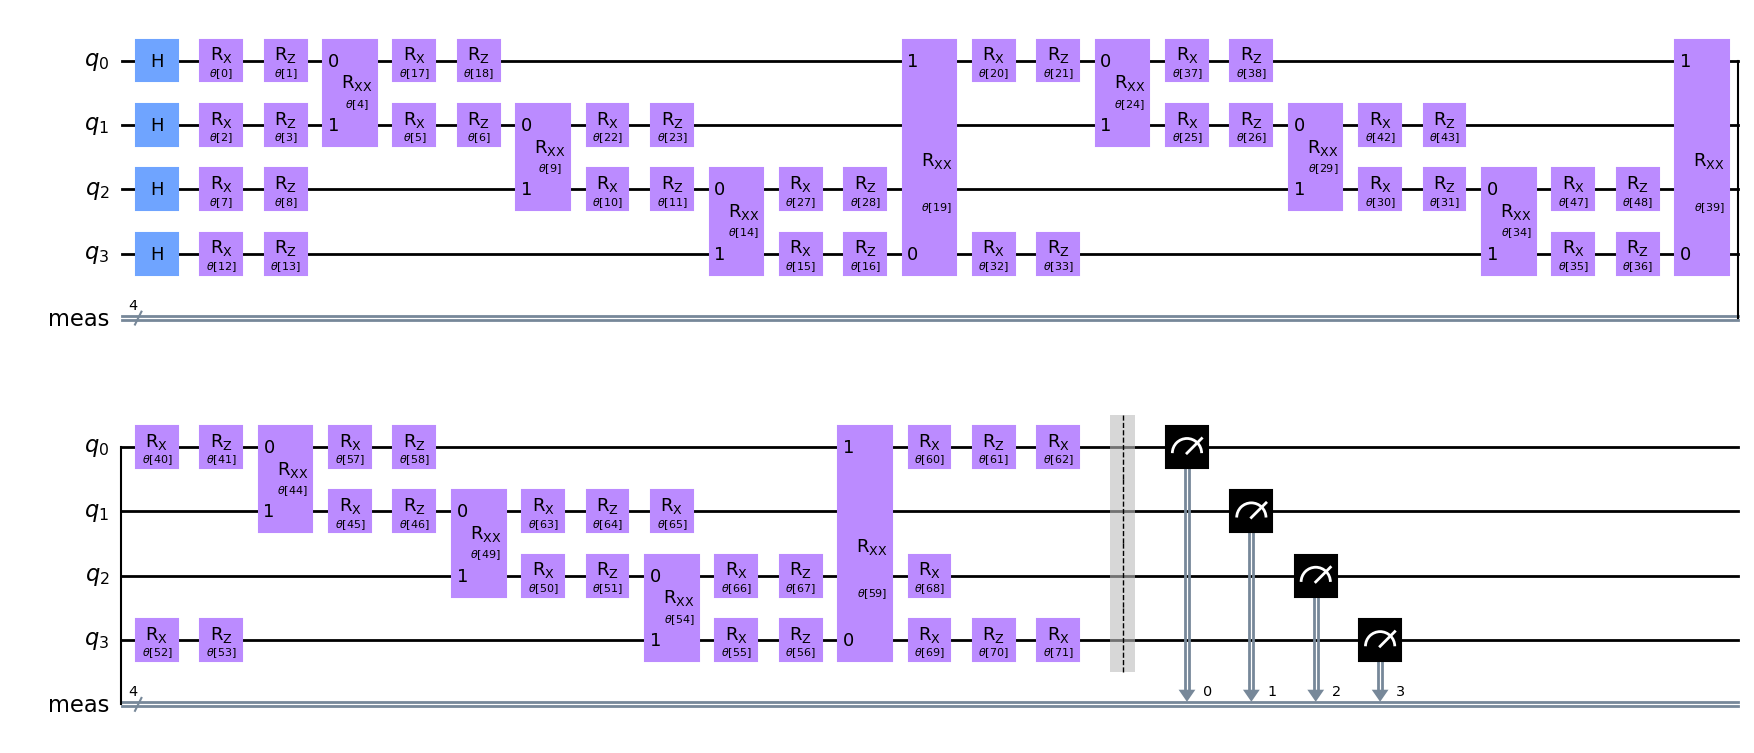

In [6]:
qc.draw(output="mpl", style="clifford")


In [7]:
# simulator = AerSimulator(device="GPU")
simulator = AerSimulator()

In [8]:
def string_to_array(string):
    ls = []
    for c in string:
        ls.append(int(c))
    return ls

def dict_to_ndarray(dict_data):
    data_array = []

    for result, count in dict_data.items():
        result = string_to_array(result)
        for i in range(count):
            data_array.append(result)
    return np.array(data_array)

def generate(parameters, shots):
    circuit = qc.assign_parameters({par_weights:parameters})
    job = simulator.run(circuit, shots=shots)
    result = job.result()
    counts_dict = result.get_counts()
    return dict_to_ndarray(counts_dict)


In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 2.0)
        m.bias.data.uniform_(-1.0, 1.0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(OUT_DIM, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, input):
#         return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 12),
            nn.LeakyReLU(0.2),
            # nn.Linear(16, 8),
            # nn.LeakyReLU(0.2),
            nn.Linear(12, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [10]:
# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# # Initialize BCELoss function
criterion = nn.BCELoss()

# def criterion(output, label):
#     return torch.mean(torch.square(output - label))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [11]:
# qc0 = qc.assign_parameters({par_weights:params})
# job = simulator.run(qc0, shots=16)
# count_dict = job.result().get_counts()

In [12]:
# count_dict

In [13]:
# generate(params, 10)

In [14]:
def updateD(real_batch, fake_batch):
    netD.zero_grad()
    real_batch = real_batch.to(device)
    b_size = real_batch.shape[0]
    label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
    output = netD(real_batch).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
    label.fill_(FAKE_LABEL)
    output = netD(fake_batch.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_g = output.mean().item()
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()
    return errD.item(), D_x, D_g


In [15]:
class GOptimizer:
    def __init__(self, alpha=spsa_alpha, gamma=spsa_gamma, c=spsa_c, A=spsa_A, a=spsa_a, netD=netD, gen=generate, loss_func = criterion, rng=rng):
        self.k = 0
        self.alpha = alpha
        self.gamma = gamma
        self.c     = c
        self.A     = A
        self.a     = a
        self.netD  = netD
        self.gen   = gen
        self.loss_func = loss_func
        self.rng = rng

    def calculate_loss(self, parameters, shots):
        fake_batch = self.gen(parameters, shots)
        fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
        with torch.no_grad():
            output = self.netD(fake_batch).view(-1)
        label = torch.full((shots,), REAL_LABEL, dtype=torch.float, device=device)
        return self.loss_func(output, label).item()

    def stochastic_gradient(self, parameters, shots):
        self.k += 1

        ck = self.c / self.k**self.gamma
        param_deltas = rng.choice([-1., 1.], size = parameters.shape) * ck
        params_plus = parameters + param_deltas
        params_minus = parameters - param_deltas

        loss_plus = self.calculate_loss(params_plus, shots)
        loss_minus = self.calculate_loss(params_minus, shots)

        return (loss_plus - loss_minus) / 2 / param_deltas

    def next_params(self, parameters, shots):
        grad = self.stochastic_gradient(parameters, shots)

        ak = self.a / (self.A + self.k) ** self.alpha
        return parameters - ak * grad




In [16]:
# # pretraining for discriminator
# for epoch in range(1):
#     for i, data in enumerate(data_loader):


#         # optimize the discriminator
#         data = data.to(device)
#         fake = generate(rng.standard_normal(n_parameters), shots=d_batch_size)
#         updateD(data, fake)

In [17]:
g_optimizer = GOptimizer()
params_init = rng.standard_normal(n_parameters)
params = params_init

In [18]:
print(params)

[-0.10796095 -0.02007454  1.3348247  -0.62583585 -0.19429983 -0.99503778
 -0.06769329  2.88293172  0.41520142  0.0792699  -0.03482242 -0.39851806
  1.4791623   0.16888473  0.41148376  0.23417729  0.62098185  0.24384747
 -1.50302314  0.47751105 -0.21322917  0.53059579 -0.48065994 -1.19902857
  0.0857287  -0.47140075 -0.56150622  1.01967756  0.38527934 -1.17302673
  0.68166486 -0.24291146  0.8960786   0.67027948  1.00936837 -0.53484755
 -0.20526366 -0.00613001 -2.22767621 -1.06678698 -3.00240604  0.22184009
 -0.4815938   0.49836287 -0.49145869 -1.70166334  1.04847279 -1.39989291
  1.07631035 -1.31747819 -0.08388393  0.95798353  0.56787306 -0.45621525
  0.6081365  -0.33122038 -1.0057595   0.16701914 -0.38093983 -2.36963184
  0.4885758   0.25612635 -0.77328805  0.50581413  0.28477969  1.37177257
 -1.12648331 -0.89320391  0.28868946  0.90767402 -0.45305578  0.51552108]


In [19]:
for epoch in range(d_pretrain_epoch):
    for i, data in enumerate(data_loader):
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=d_batch_size)
        loss_D, D_x, D_g = updateD(data, fake)

In [20]:


G_losses = []
D_losses = []

start = time.time()
now = start

print("Starting Training Loop...")

for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):


        
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=d_batch_size)
        for j in range(d_repeats):
            loss_D, D_x, D_g = updateD(data, fake)

        # this part is not important
        with torch.no_grad():
            output = netD(torch.tensor(fake, device=device, dtype=torch.float)).view(-1)
            labels = torch.full((fake.shape[0],), REAL_LABEL, dtype=torch.float, device=device)
            loss_G = criterion(output, labels)


        if epoch < epoch_1:
            g_repeats = g_repeats_1
        else:
            g_repeats = g_repeats_2
        # optimize the generator
        for j in range(g_repeats):
            params = g_optimizer.next_params(params, g_batch_size)


        # print output
        if i%10 == 0:
            G_losses.append(loss_G)
            D_losses.append(loss_D)

            last, now = now, time.time()
            print(f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLossD: {loss_D:.4f}\tLossG: {loss_G:.4f}\t" +
                f"D(x): {D_x:.4f}\tD(G(x)): {D_g:.4f}\tTime: {now-last:.1f}s")
        


Starting Training Loop...
[0/20][0/640]	LossD: 0.8556	LossG: 7.3916	D(x): 0.8268	D(G(x)): 0.3058	Time: 0.0s
[0/20][10/640]	LossD: 0.6339	LossG: 7.5222	D(x): 0.7966	D(G(x)): 0.2006	Time: 0.1s
[0/20][20/640]	LossD: 0.7072	LossG: 7.8662	D(x): 0.7794	D(G(x)): 0.2236	Time: 0.1s
[0/20][30/640]	LossD: 0.8515	LossG: 7.1389	D(x): 0.7936	D(G(x)): 0.3165	Time: 0.1s
[0/20][40/640]	LossD: 0.6509	LossG: 5.4146	D(x): 0.7860	D(G(x)): 0.2167	Time: 0.1s
[0/20][50/640]	LossD: 0.3728	LossG: 8.8851	D(x): 0.8028	D(G(x)): 0.0758	Time: 0.1s
[0/20][60/640]	LossD: 0.6818	LossG: 7.0271	D(x): 0.7575	D(G(x)): 0.2096	Time: 0.1s
[0/20][70/640]	LossD: 0.7991	LossG: 5.7896	D(x): 0.7595	D(G(x)): 0.2809	Time: 0.1s
[0/20][80/640]	LossD: 0.6516	LossG: 7.2329	D(x): 0.7592	D(G(x)): 0.2061	Time: 0.1s
[0/20][90/640]	LossD: 0.6026	LossG: 8.3705	D(x): 0.7227	D(G(x)): 0.1393	Time: 0.1s
[0/20][100/640]	LossD: 0.7144	LossG: 7.2068	D(x): 0.8076	D(G(x)): 0.2620	Time: 0.1s
[0/20][110/640]	LossD: 0.8535	LossG: 5.2549	D(x): 0.7696	D(G(

In [21]:
finish = time.time()
print(f"Training takes {round(finish-start)}s.")

Training takes 76s.


In [22]:
print(params)

[-0.18929287  0.12667814  1.34847353 -0.26001966 -0.08385521 -1.32953062
 -0.13252617  3.07577648  0.65266813 -0.07278432 -0.06719324 -0.34874512
  1.41516547  0.24077936  0.48217578  0.35159564  0.75225848  0.22843114
 -1.26753159  0.30293244 -0.16920054  0.68313859 -0.67714157 -0.85083181
  0.09676905 -0.25376207 -0.77765635  0.92629565  0.83162351 -1.39275391
  0.3841842  -0.04264709  0.74112154  0.8546023   0.73804572 -0.57561348
 -0.2313692  -0.08030754 -2.43215894 -0.90684292 -2.65205477  0.37458394
 -0.16226081  0.74665178 -0.44326679 -1.668127    1.30392586 -1.38819822
  1.570887   -1.5816105  -0.22849434  0.99704849  0.36727387 -0.34614955
 -0.08702272 -0.46622296 -0.94576171  0.0399145  -0.03040456 -2.012726
  0.17267328  0.39425776 -0.70014007  0.35671491  0.74090951  1.38006206
 -0.28738285 -0.6103844   0.4637381   0.78105562 -0.33498706  0.24592432]


In [23]:
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

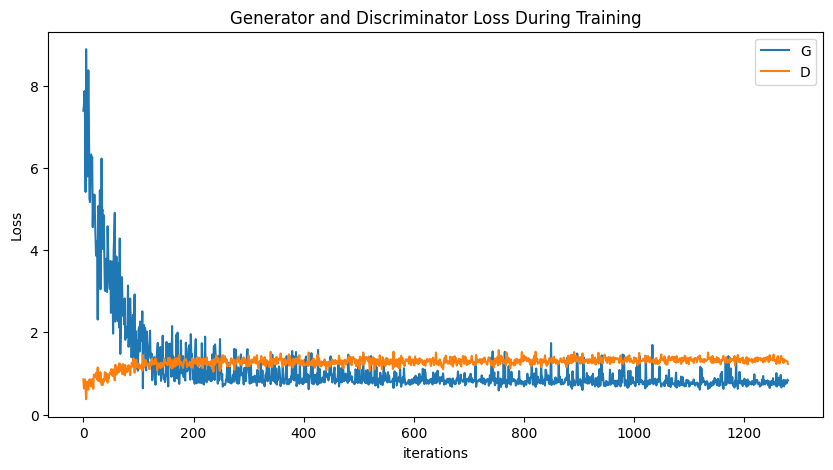

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(os.path.join(save_folder, "loss.png"))

In [25]:
n_rows = 4
n_cols = 4

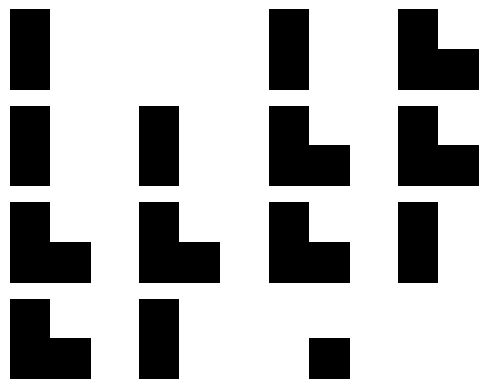

In [26]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")
fig.savefig(os.path.join(save_folder, "real_images.png"))


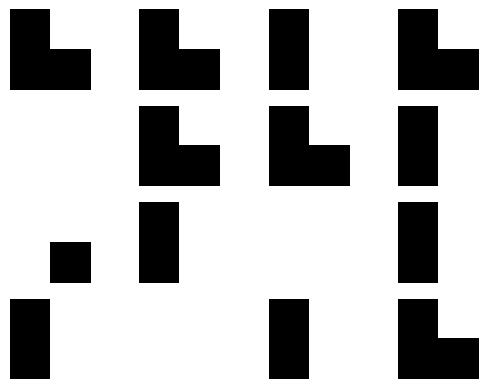

In [27]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

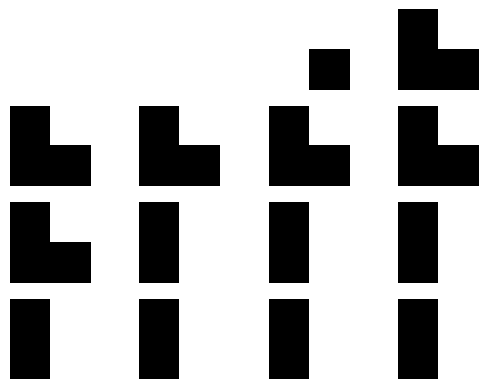

In [28]:
b_size = n_rows * n_cols

fake_batch = generate(params, b_size)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2), cmap="binary")
fig.savefig(os.path.join(save_folder, "fake_images.png"))


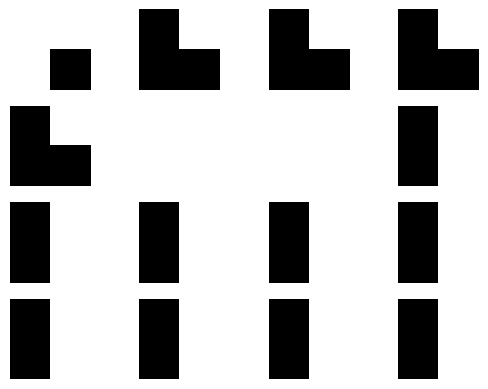

In [29]:
b_size = n_rows * n_cols

fake_batch = generate(params, b_size)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2), cmap="binary")

In [30]:
sample_size = 10000
data_index = torch.randperm(data_true.shape[0])[:sample_size]
real_samples = data_true[data_index]

fake_samples = generate(params, sample_size)

np.savez(save_folder + "/samples.npz", 
    real_samples = real_samples.cpu(), 
    fake_samples = fake_samples
)

In [31]:
with torch.no_grad():
    real_scores = netD(real_samples).cpu()
    fake_scores = netD(torch.tensor(fake_samples, device=device, dtype=torch.float)).cpu()

In [32]:
print(np.mean(real_scores.numpy()))
print(np.mean(fake_scores.numpy()))


0.5350997
0.4798688


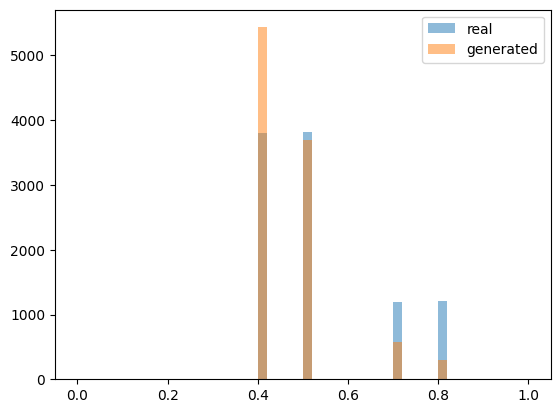

In [33]:
fig, ax = plt.subplots()



ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="real")
ax.hist(fake_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")

ax.legend()

fig.savefig(os.path.join(save_folder, "hist.png"))


In [34]:
for p in netD.parameters():
    print(p)

Parameter containing:
tensor([[ 1.7664,  2.7786, -0.3449,  2.0853],
        [-5.8462, -0.1997, -2.9445,  1.7214],
        [-0.1310, -1.5261,  0.5383, -1.6668],
        [-0.8375, -0.2326,  4.7341,  0.7964],
        [-2.1032, -3.6161, -2.4759,  1.6172],
        [ 0.2357, -3.6406,  0.5865,  0.7580],
        [ 1.8786,  0.5259, -2.2955, -0.3872],
        [-0.1702, -0.5768, -2.5665,  1.7087],
        [-3.8805, -1.5909, -0.2734,  3.9368],
        [-2.4258,  4.3105,  3.5562,  0.7977],
        [-2.1232, -2.6680, -1.9199,  0.7126],
        [-0.2949, -0.7563,  3.2520,  2.2962]], requires_grad=True)
Parameter containing:
tensor([-0.2037,  0.7295,  0.6111, -0.2673,  0.4549, -0.0336,  0.8185, -1.0311,
         0.1883,  0.4123,  0.6606,  0.4677], requires_grad=True)
Parameter containing:
tensor([[-1.1815,  2.4379,  1.1589, -3.4169, -0.8594, -0.7689,  0.7826,  1.9888,
         -1.4260,  3.2073,  0.9413, -0.9660],
        [ 0.8628, -1.0763, -1.2446,  5.0088,  0.0326, -2.9902,  2.9901,  2.5857,
        

In [35]:
# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [36]:
netEv = Evaluator().to(device)
netEv.apply(weights_init)

optimizer_ev = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv)

Evaluator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [37]:
batch_size_ev = 16

In [38]:
real_samples_np = real_samples.cpu().numpy()
fake_samples_np = fake_samples

samples = np.concatenate((real_samples_np, fake_samples_np))

real_labels = np.repeat(REAL_LABEL, real_samples_np.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples_np.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader_ev = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size_ev, shuffle = True)


In [39]:
valid_losses = []
train_losses = []
iters = 0

netEv.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv.eval()
            with torch.no_grad():
                prediction_valid = netEv(X_valid).view(-1)
                prediction_train = netEv(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv.train()

            print(
                f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[0/20][0/640]	Loss train: 43.852	Loss valid: 44.224	Loss acc: 0.500
[0/20][50/640]	Loss train: 43.261	Loss valid: 43.674	Loss acc: 0.500
[0/20][100/640]	Loss train: 42.729	Loss valid: 43.166	Loss acc: 0.500
[0/20][150/640]	Loss train: 42.126	Loss valid: 42.602	Loss acc: 0.500
[0/20][200/640]	Loss train: 41.803	Loss valid: 42.299	Loss acc: 0.500
[0/20][250/640]	Loss train: 41.612	Loss valid: 42.125	Loss acc: 0.500
[0/20][300/640]	Loss train: 41.413	Loss valid: 41.943	Loss acc: 0.500
[0/20][350/640]	Loss train: 41.363	Loss valid: 41.897	Loss acc: 0.500
[0/20][400/640]	Loss train: 41.323	Loss valid: 41.860	Loss acc: 0.534
[0/20][450/640]	Loss train: 41.302	Loss valid: 41.840	Loss acc: 0.534
[0/20][500/640]	Loss train: 41.306	Loss valid: 41.844	Loss acc: 0.534
[0/20][550/640]	Loss train: 41.301	Loss valid: 41.840	Loss acc: 0.534
[0/20][600/640]	Loss train: 41.319	Loss valid: 41.856	Loss acc: 0.534
[0/20][650/640]	Loss train: 41.335	Loss valid: 41.871	Loss acc: 0.

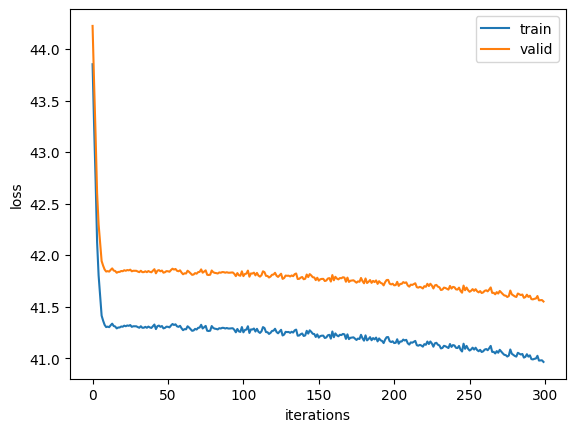

In [40]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [41]:
netEv.eval()

with torch.no_grad():
    prediction_test = netEv(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.53


In [42]:
print(f"AUC score is {roc_auc_score(y_test, prediction_test)}")

AUC score is 0.578805125


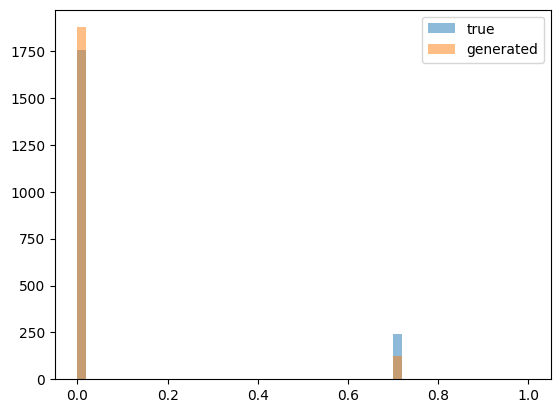

In [43]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots()
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

None